=============================================================
# 1. Setup
=============================================================

## Importing Relevant Libraries

#### General

In [1]:
import pandas as pd
import numpy as np

#### For scaling the data

In [2]:
from sklearn.preprocessing import StandardScaler, normalize

#### For clustering

In [3]:
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score

#### For principal component analysis

In [4]:
from sklearn.decomposition import PCA

#### For plotting

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

=============================================================
# 2. Read in the data
=============================================================

### Read in data from PVL-Delta model

In [6]:
df_pvl_delta = pd.read_csv("./data/parameter_igt_pvl_delta.csv")

#### Inspect the data

In [7]:
df_pvl_delta.head()

,group,SubID,LR,Outcome_Sens,Response_cons,Loss_Aver
0,young,1,0.159011,0.487522,0.686815,0.954498
1,young,2,0.064666,0.511008,1.391790,0.295529
2,young,3,0.113089,0.465141,0.918734,0.533232
3,young,4,0.089273,0.500391,0.703737,0.869859
4,young,5,0.233898,0.488053,0.897867,0.511095


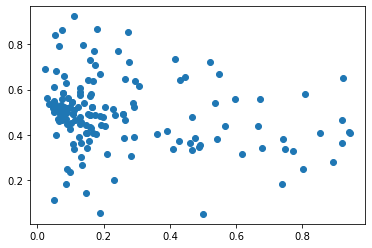

In [8]:
plt.scatter(df_pvl_delta["LR"], df_pvl_delta["Outcome_Sens"])

#### Processing
'SubID' column can be dropped as it is not used for analysis.

In [9]:
df_pvl_delta.drop(columns=['SubID'], inplace=True)

In [10]:
df_pvl_delta.head()

,group,LR,Outcome_Sens,Response_cons,Loss_Aver
0,young,0.159011,0.487522,0.686815,0.954498
1,young,0.064666,0.511008,1.391790,0.295529
2,young,0.113089,0.465141,0.918734,0.533232
3,young,0.089273,0.500391,0.703737,0.869859
4,young,0.233898,0.488053,0.897867,0.511095


### Read in data from the ORL model

In [11]:
df_orl = pd.read_csv("./data/parameter_igt_orl.csv")

#### Inspect the data

In [12]:
df_orl.head()

,subjID,A+,A-,K,BetaF,BetaP,A+-A-
0,old,0.324444,0.068862,1.502130,2.523191,-5.547480,0.255581
1,old,0.885744,0.120145,0.012591,3.193244,-9.159800,0.765598
2,old,0.318205,0.078128,1.927309,0.615708,9.272336,0.240077
3,old,0.728192,0.106737,0.388407,2.595746,-2.239555,0.621455
4,old,0.356229,0.091987,1.810674,0.508605,9.825699,0.264241


#### Processing
'subjID' column in input file is actually the 'group' column based on its contents. Thus, rename the column as so.

In [13]:
df_orl.rename(columns={'subjID':'group'}, inplace=True)
df_orl.head()

,group,A+,A-,K,BetaF,BetaP,A+-A-
0,old,0.324444,0.068862,1.502130,2.523191,-5.547480,0.255581
1,old,0.885744,0.120145,0.012591,3.193244,-9.159800,0.765598
2,old,0.318205,0.078128,1.927309,0.615708,9.272336,0.240077
3,old,0.728192,0.106737,0.388407,2.595746,-2.239555,0.621455
4,old,0.356229,0.091987,1.810674,0.508605,9.825699,0.264241


### Read in data from the VPP model

In [14]:
df_vpp = pd.read_csv("./data/parameters_igt_vpp.csv")

#### Inspect the data

In [15]:
df_vpp.head()

,group,SubID,LR,Out_Sens,Res_Cons,Loss_Aver,Gain_Impa,Loss_Impa,Deca_Rate,RL_weight
0,young,1,0.038441,0.630402,1.207295,1.050323,-0.535035,-1.913099,0.669323,0.660446
1,young,2,0.045673,0.630331,1.628191,0.205205,-0.133367,-1.423580,0.427207,0.719352
2,young,3,0.045468,0.602974,1.395572,0.383055,-0.344822,-1.719826,0.493249,0.688723
3,young,4,0.035789,0.635677,1.067831,0.823790,-0.229192,-1.484455,0.625835,0.675971
4,young,5,0.060655,0.636276,1.802964,0.329246,-0.616020,-2.561017,0.439912,0.655563


#### Processing
'SubID' column is dropped as before as it is not used for analysis.

In [16]:
df_vpp.drop(columns=['SubID'], inplace=True)
df_vpp.head()

,group,LR,Out_Sens,Res_Cons,Loss_Aver,Gain_Impa,Loss_Impa,Deca_Rate,RL_weight
0,young,0.038441,0.630402,1.207295,1.050323,-0.535035,-1.913099,0.669323,0.660446
1,young,0.045673,0.630331,1.628191,0.205205,-0.133367,-1.423580,0.427207,0.719352
2,young,0.045468,0.602974,1.395572,0.383055,-0.344822,-1.719826,0.493249,0.688723
3,young,0.035789,0.635677,1.067831,0.823790,-0.229192,-1.484455,0.625835,0.675971
4,young,0.060655,0.636276,1.802964,0.329246,-0.616020,-2.561017,0.439912,0.655563


=============================================================
# 3. Standardise the data
=============================================================

#### Choose which data source to use

In the paper, Lili concludes that the VPP model was the best-fitting model in terms of short-term prediction performance for the IGT task, as measured by one-step-ahead leave-one-out information criterion (LOOIC) [1]. Therefore, we will begin by analysing this dataset.

In [17]:
chosen_df = df_vpp

* The *'group'* column will not be used as a feature for the clustering analysis, so we will exclude this from the processing for now.

In [18]:
train_df = chosen_df.drop(columns=["group"])

We can describe the data in this DataFrame and look at the ranges of the variables and their distributions

In [19]:
train_df.describe()

,LR,Out_Sens,Res_Cons,Loss_Aver,Gain_Impa,Loss_Impa,Deca_Rate,RL_weight
count,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000
mean,0.070824,0.560575,1.329323,0.952138,0.460940,-0.720379,0.406367,0.622995
std,0.064683,0.111139,0.198041,0.580621,1.185591,1.102656,0.187483,0.066657
min,0.027454,0.352471,0.879707,0.193857,-2.977630,-2.912838,0.042780,0.452978
25%,0.038294,0.448811,1.202790,0.528927,-0.287230,-1.634716,0.256420,0.569390
50%,0.050247,0.590334,1.316736,0.760613,0.593115,-0.779120,0.439912,0.640917
75%,0.078495,0.646090,1.428836,1.292569,1.419412,0.137599,0.565139,0.675971
max,0.617431,0.818137,1.938694,2.698527,2.559126,1.583109,0.858421,0.744017


#### Visualising the distributions of the different variables

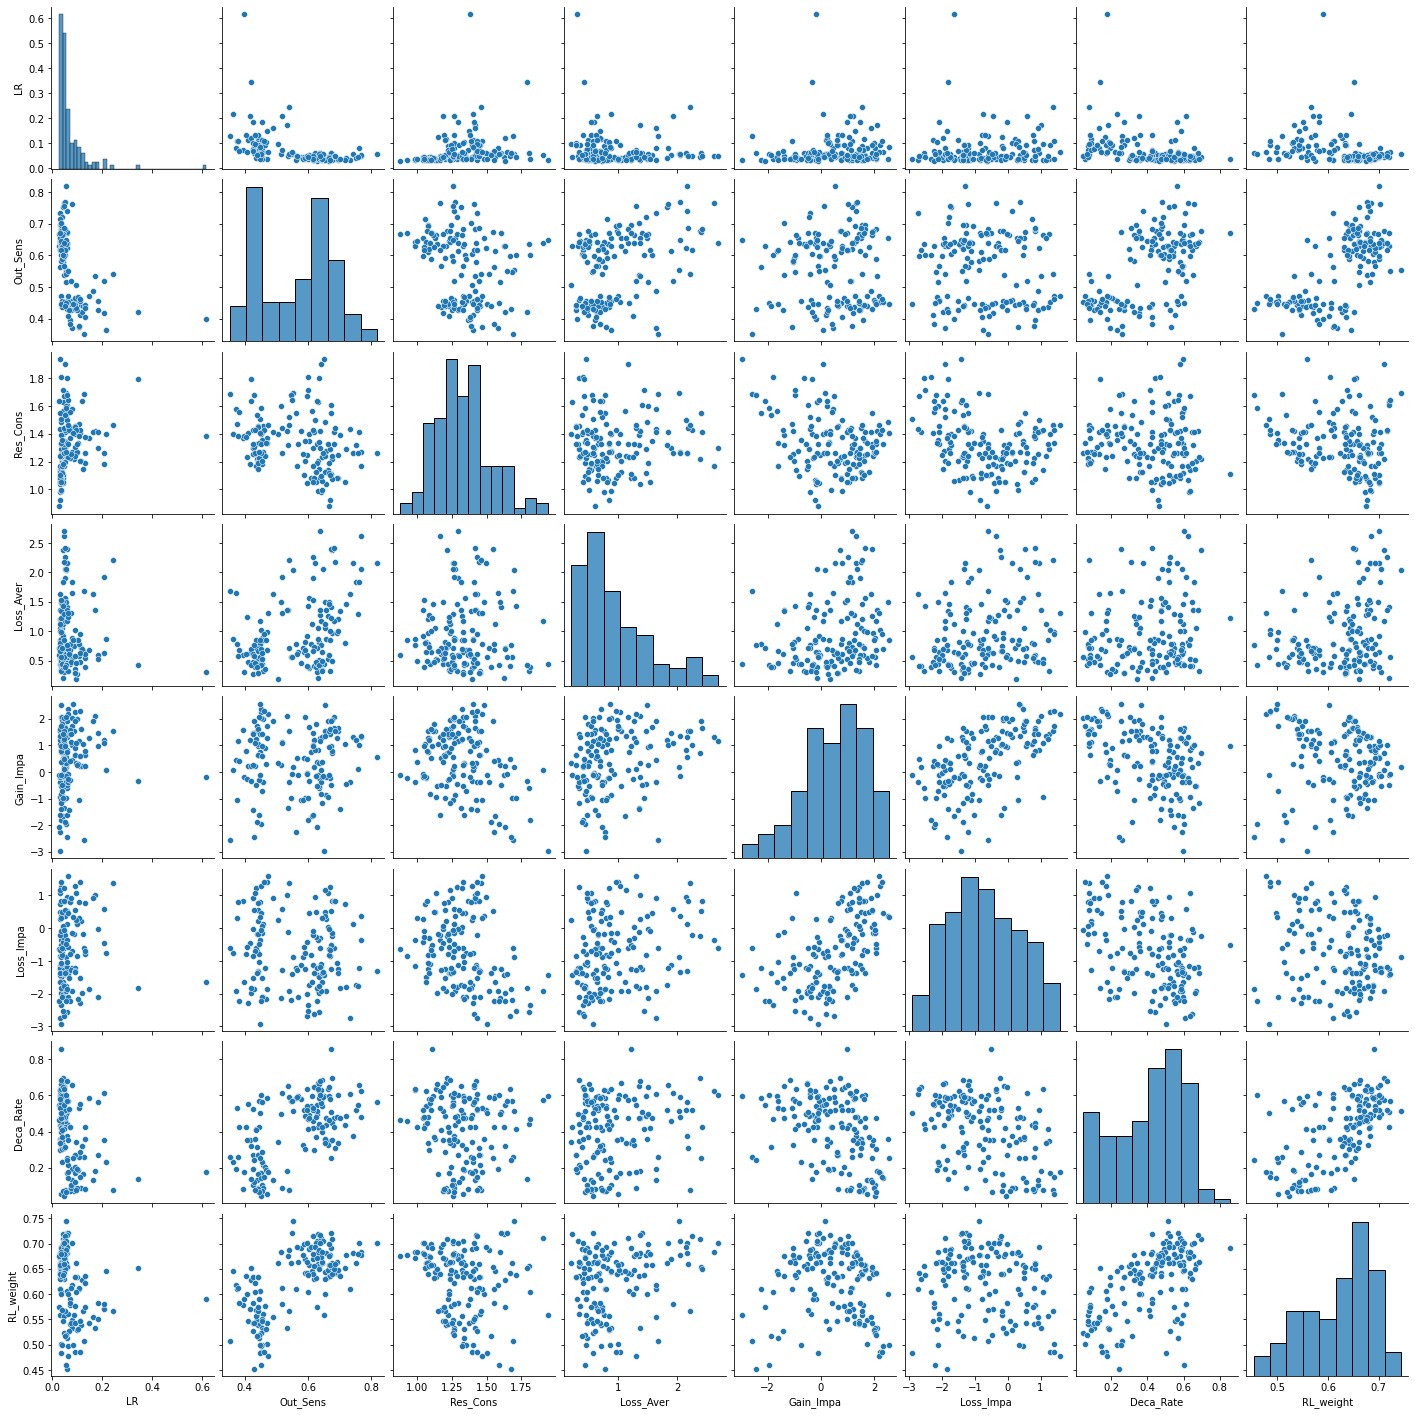

In [99]:
sns.pairplot(train_df)

From the pair plot above, we can clearly see that many of the variables have either positively or negatively skewed distributions. There also appears to be many outliers in each distribution and the different parameters don't share a common scale.

To remedy this and also to ensure sound clustering analysis, we are going to **standardise** the dataset.

#### Scaling and normalising the features

In [21]:
# Standardising the data
standardised_train_array = StandardScaler().fit_transform(train_df)

# Normalizing the data
normalised_nd_standardised_train_array = normalize(standardised_train_array, axis=0)

# Converting the scaled array back to a DataFrame
scaled_train_df = pd.DataFrame(normalised_nd_standardised_train_array, columns=train_df.columns)

In [22]:
scaled_train_df.describe()

,LR,Out_Sens,Res_Cons,Loss_Aver,Gain_Impa,Loss_Impa,Deca_Rate,RL_weight
count,1.530000e+02,1.530000e+02,1.530000e+02,1.530000e+02,153.000000,1.530000e+02,1.530000e+02,1.530000e+02
mean,-2.902544e-18,1.161018e-17,2.031781e-17,1.451272e-18,0.000000,2.902544e-18,-1.161018e-17,-2.612289e-17
std,8.111071e-02,8.111071e-02,8.111071e-02,8.111071e-02,0.081111,8.111071e-02,8.111071e-02,8.111071e-02
min,-5.438584e-02,-1.518770e-01,-1.841472e-01,-1.059293e-01,-0.235245,-1.612760e-01,-1.572984e-01,-2.068814e-01
25%,-4.079214e-02,-8.156703e-02,-5.182350e-02,-5.912117e-02,-0.051185,-6.725810e-02,-6.487139e-02,-6.522806e-02
50%,-2.580297e-02,2.171851e-02,-5.155164e-03,-2.675543e-02,0.009043,-4.320979e-03,1.451265e-02,2.180811e-02
75%,9.618559e-03,6.240928e-02,4.075695e-02,4.755704e-02,0.065573,6.311234e-02,6.868974e-02,6.446273e-02
max,6.854293e-01,1.879718e-01,2.495777e-01,2.439647e-01,0.143545,1.694432e-01,1.955719e-01,1.472632e-01


#### Add the group feature back in

Since the data is now fully processed and ready for clustering, we can add the *'group'* column back in as it will be needed later on.

In [23]:
scaled_full_df = pd.concat([chosen_df["group"], scaled_train_df], axis=1)

In [24]:
scaled_full_df.head()

,group,LR,Out_Sens,Res_Cons,Loss_Aver,Gain_Impa,Loss_Impa,Deca_Rate,RL_weight
0,young,-0.040608,0.050960,-0.049978,0.013716,-0.068138,-0.087736,0.113763,0.045572
1,young,-0.031540,0.050908,0.122406,-0.104344,-0.040659,-0.051727,0.009016,0.117250
2,young,-0.031797,0.030943,0.027133,-0.079499,-0.055125,-0.073519,0.037588,0.079980
3,young,-0.043933,0.054810,-0.107098,-0.017930,-0.047214,-0.056205,0.094949,0.064463
4,young,-0.012752,0.055247,0.193987,-0.087016,-0.073679,-0.135396,0.014513,0.039631


=============================================================
# 4. Consideration of clustering algorithms and optimal number of clusters
=============================================================

There are a number of clustering algorithms which we could implement. Below, we try the *KMeans* and *Spectral Clustering* algorithms and analyse how these perform on the data in question. 

To determine which algorithm is more appropriate to the dataset, we will measure their performance using the *Silhouette Coefficient*. The Silhouette Coefficient of a data point quantifies how similar a data point is to its own cluster compared to other clusters. We will use the mean Silhouette Coefficient across all data points to compare the performace of algorithms.

The **Silhouette Coefficient** for a particular data point is calculated by the below formula:

$$s = \frac{b - a}{max(a, b)}$$

Where:

 - **a** is the mean distance between a data point and all other points in the same cluster. (the mean intra-cluster distance)
 - **b** is the mean distance between a data point and all other points in the *next nearest cluster*. (the mean nearest-cluster distance)

The Silhouette score can assume values between -1 and 1. Scores closer to -1 indicate incorrect clustering whereas those nearer to +1 indicate highly dense clustering. Scores around zero are indicative of overlapping clusters. Therefore, a good indicator of what clustering algorithm to choose would be the one whose mean Silhouette Coefficient is nearest to 1 [5].

#### Choose the number of clusters to test these algorithms on

In [25]:
num_clusters_to_iter = range(2, 11)

#### Choose the random seed number for reproducibility

In [26]:
random_seed_val = 127

#### Define the functions for calculating the silhouette scores of the different models

In [27]:
def get_silhouette_scores_list(scaled_train_df, model_function, num_clusters_to_itr, random_seed_val, affinity_value=None):
    
    # Initialise empty list for the Silhouette Scores for KMeans model
    s_scores = []

    # Running algorithm and calculating Silhouette Score
    for k in num_clusters_to_iter:

        # Building the clustering model
        if affinity_value:
            model = model_function(n_clusters = k, random_state = random_seed_val, affinity = affinity_value)
            
        else:
            model = model_function(n_clusters = k, random_state = random_seed_val)
        
        # Training the model and storing the predicted cluster labels
        labels = model.fit_predict(scaled_train_df)

        # Evaluating the performance and adding score to list
        s_scores.append(silhouette_score(scaled_train_df, labels))

    return s_scores

In [28]:
def analyse_silhouette_scores_to_get_optimal_cluster_number(silhouette_score_list, num_clusters_to_iter):
    
    # Analyse these results to see the optimal cluster number
    max_silhouette_score = max(silhouette_score_list)
    index_max_score = silhouette_score_list.index(max_silhouette_score)

    print("The maximum Silhouette Score was", max_silhouette_score)
    print("This score is achieved by running", num_clusters_to_iter[index_max_score], "clusters")

    # plot the silhoutte scores against the cluster numbers
    plt.plot(num_clusters_to_iter, silhouette_score_list, 'bx-')
    plt.xlabel('# Clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette scores for the model accross a different number of clusters')
    plt.show()

    # Output a table of the score for each cluster
    cluster_nd_score_df = pd.DataFrame(silhouette_score_list, index=num_clusters_to_iter).rename(columns={0: "Silhouette Score"})
    cluster_nd_score_df.index.name = "# Clusters"
    
    return cluster_nd_score_df.T

## Silhouette Scores for the KMeans Algorithm

Below the KMeans algorithm is executed with various different numbers of clusters (from 2 clusters to 10). The mean Silhouette Coefficient (or more simply, the *Silhouette Score*) for the clusters produced is calculated for each execution of the algorithm. These scores are plotted below.

#### Use K-Means to calculate the Silhouette Score for 2-10 clusters

In [29]:
s_scores_km = get_silhouette_scores_list(scaled_train_df, KMeans, num_clusters_to_iter, random_seed_val)

#### Analyse these scores and output & plot the score

The maximum Silhouette Score was 0.29512958858192134
This score is achieved by running 2 clusters


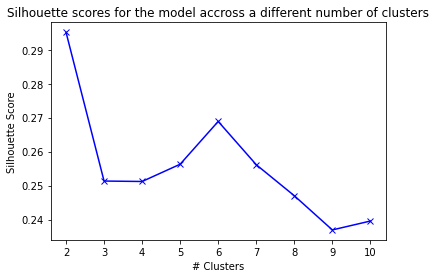

# Clusters,2,3,4,5,6,7,8,9,10
Silhouette Score,0.29513,0.251348,0.251219,0.2563,0.268886,0.25616,0.247031,0.236969,0.239581


In [30]:
cluster_nd_score_km_df = analyse_silhouette_scores_to_get_optimal_cluster_number(s_scores_km, num_clusters_to_iter)
cluster_nd_score_km_df

## Silhouette Scores for the Spectral Clustering Algorithm

In order to explore more options for clustering, we are going to test the performance of two different implementations of the Spectral Clustering algorithm. One implementation constructs the *affinity matrix* using a radial basis function (RBF) kernel (aka Gaussian kernel) while the other constructs this matrix by computing a graph of nearest neighbors.

### Spectral Clustering with *affinity='rbf'*

#### Use Spectral Clustering to calculate the Silhouette Score for 2-10 clusters

In [31]:
s_scores_rbf = get_silhouette_scores_list(scaled_train_df, SpectralClustering, num_clusters_to_iter, random_seed_val, 'rbf')

#### Analyse these scores and output & plot the score

The maximum Silhouette Score was 0.29512958858192134
This score is achieved by running 2 clusters


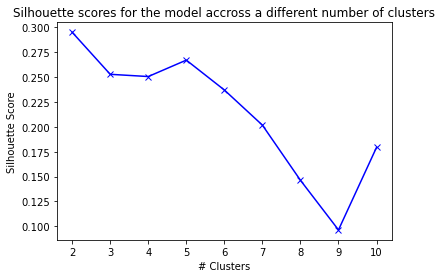

# Clusters,2,3,4,5,6,7,8,9,10
Silhouette Score,0.29513,0.252844,0.25059,0.267099,0.237073,0.201738,0.146303,0.096382,0.179345


In [32]:
cluster_nd_score_rbf_df = analyse_silhouette_scores_to_get_optimal_cluster_number(s_scores_rbf, num_clusters_to_iter)
cluster_nd_score_rbf_df

### Spectral Clustering with *affinity='nearest_neighbors'*

#### Use Spectral Clustering to calculate the Silhouette Score for 2-10 clusters

In [33]:
s_scores_nn = get_silhouette_scores_list(scaled_train_df, SpectralClustering, num_clusters_to_iter, random_seed_val, 'nearest_neighbors')

#### Analyse these scores and output & plot the score

The maximum Silhouette Score was 0.29512958858192134
This score is achieved by running 2 clusters


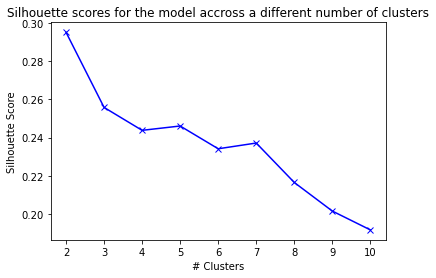

# Clusters,2,3,4,5,6,7,8,9,10
Silhouette Score,0.29513,0.255765,0.243764,0.246033,0.234108,0.237116,0.216459,0.201482,0.191615


In [34]:
cluster_nd_score_nn_df = analyse_silhouette_scores_to_get_optimal_cluster_number(s_scores_nn, num_clusters_to_iter)
cluster_nd_score_nn_df

As we can see from the above results, running these clustering algorithms on this data using **two clusters** produces the best Silhouette Scores for all three algorithms.

One reason that we can see why this might be the case is that the sample of data subjects can be segmented into two groups as we saw at the start; *'young'* and *'old'* and these two clusters could just be encapsulating these two groups.
To test this, we will attempt to visualise these clusters.

From the above ouputs, we can see that all three algorithms get the same Silhouette Score for two clusters. As a result, we could choose any of the algorithms to test our hypothesis.

As the Spectral Clustering algorithm is more robust than KMeans, we will test this first, constructuing the affinity matrix using a radial basis function kernel (*affinity='rbf'*).

#### Choose the number of clusters to use

In [35]:
num_clusters = 2

=============================================================
# 5. Cluster the data using 2 clusters
=============================================================

#### Build the 'rbf' spectral clustering model with these 2 clusters

In [36]:
spectral_model = SpectralClustering(n_clusters=num_clusters, affinity='rbf', random_state=random_seed_val)

#### Training the model and storing predicted cluster labels

In [37]:
cluster_labels_array = spectral_model.fit_predict(scaled_train_df)

#### Turn this array to a dataframe so it can be concatenated with the rest of the data

In [38]:
cluster_labels_df = pd.DataFrame(cluster_labels_array, columns=["Cluster"])

In [39]:
cluster_labels_df.head()

,Cluster
0,0
1,0
2,0
3,0
4,0


#### Add a new column to the original data with the cluster each data point is in

In [40]:
full_df_nd_cluster = pd.concat([chosen_df, cluster_labels_df], axis=1)

In [41]:
full_df_nd_cluster.head()

,group,LR,Out_Sens,Res_Cons,Loss_Aver,Gain_Impa,Loss_Impa,Deca_Rate,RL_weight,Cluster
0,young,0.038441,0.630402,1.207295,1.050323,-0.535035,-1.913099,0.669323,0.660446,0
1,young,0.045673,0.630331,1.628191,0.205205,-0.133367,-1.423580,0.427207,0.719352,0
2,young,0.045468,0.602974,1.395572,0.383055,-0.344822,-1.719826,0.493249,0.688723,0
3,young,0.035789,0.635677,1.067831,0.823790,-0.229192,-1.484455,0.625835,0.675971,0
4,young,0.060655,0.636276,1.802964,0.329246,-0.616020,-2.561017,0.439912,0.655563,0


Now that we have clustered this data based on the parameters, we want to verify our hypothesis that these 2 clusters will just contain the 'young' and 'old' groups exclusively.

We want to analyse these clusters to see how the 'old' and 'young' fall into these clusters and test this.

=============================================================
# 6. Analyse these 2 clusters
=============================================================

#### Create function to see how the young and old people are distributed within each cluster

In [42]:
def see_how_the_young_and_old_fall_into_the_clusters(input_df):
    
    # copy the dataframe so that we arent overwriting the input dataframe
    df = input_df.copy()
    
    # Create a dataframe showing how many people fell into each cluster
    all_cluster_df = pd.DataFrame(df[["group", "Cluster"]].groupby("Cluster").count()).rename(columns={"group": "All"})
    
    # Change 'young' to 1 and 'old' to np.nan in the group column
    df["group"] = df["group"].replace('old', np.nan).replace('young', 1)
    
    # Create a dataframe showing how many young people fell into each cluster
    young_cluster_df = pd.DataFrame(df[["group", "Cluster"]].groupby("Cluster").count()).rename(columns={"group": "Young"})
    
    # Create a dataframe showing how many old people fell into each cluster
    old_cluster_df = pd.DataFrame(df["group"].isnull().groupby(df["Cluster"]).sum().astype(int)).rename(columns={"group": "Old"})
    
    # Output how many 'young' and 'old' people fell into each cluster
    return pd.merge(all_cluster_df, pd.merge(young_cluster_df, old_cluster_df, how="inner", on="Cluster"), how="inner", on="Cluster")

#### Check the distribution of young and old people among the 2 clusters

In [43]:
see_how_the_young_and_old_fall_into_the_clusters(full_df_nd_cluster)

,All,Young,Old
Cluster,,,
0,90,90,0
1,63,0,63


As you can see from the above table, our hypothesis was correct and the algorithm clustered the individuals into their respective age groups of 'young' and 'old'.

While this test did not provide us with any more information than we already had, we felt it was vital to not make any assumptions and verify the results we expected to see.
So, even though from our analysis using the *Silhouette Score* we identified that two clusters maximised this score; this is because of how distinct the two groups of subjects are when it comes to decision-making and does not provide us with much insight. As a result, we are going to experiment with a different number of clusters and see if we can segement the subject group based on the different cognitive processes underlying the decision choices.

=============================================================
# 7. Re-consider the clustering algorithms and the number of clusters
=============================================================

So we have experimented using two clusters and have decided that this does not provide us with enough aditional information to satisfy our analysis.


#### Create function to output the silhoette scores excluding two clusters

In [44]:
def take_in_a_dataframe_of_an_algorithms_silhouette_scores_and_output_analysis_excluding_cluster_2(cluster_nd_score_df):
    
    # remove cluster 2 from this dataframe
    cluster_nd_score_df_no_2 = cluster_nd_score_df.drop(columns=[2], axis=1)

    # get the silhouette scores and cluster number
    s_scores_without_2 = list(cluster_nd_score_df_no_2.iloc[0, :])
    num_clusters_to_iter_without_2 = cluster_nd_score_df_no_2.columns

    # analyse these scores
    return analyse_silhouette_scores_to_get_optimal_cluster_number(s_scores_without_2, num_clusters_to_iter_without_2)

## Silhouette Scores for the KMeans Algorithm (excluding two clusters)

The maximum Silhouette Score was 0.26888600929104295
This score is achieved by running 6 clusters


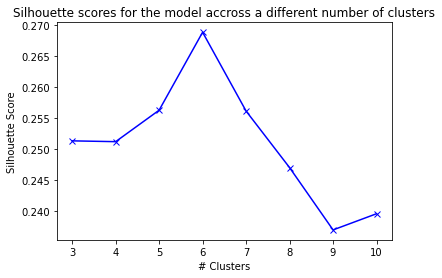

# Clusters,3,4,5,6,7,8,9,10
Silhouette Score,0.251348,0.251219,0.2563,0.268886,0.25616,0.247031,0.236969,0.239581


In [45]:
take_in_a_dataframe_of_an_algorithms_silhouette_scores_and_output_analysis_excluding_cluster_2(cluster_nd_score_km_df)

## Silhouette Scores for Spectral Clustering Algorithm (excluding two clusters)

### Spectral Clustering with *affinity='rbf'* (excluding two clusters)

The maximum Silhouette Score was 0.26709917646414355
This score is achieved by running 5 clusters


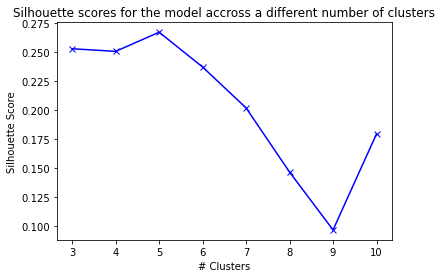

# Clusters,3,4,5,6,7,8,9,10
Silhouette Score,0.252844,0.25059,0.267099,0.237073,0.201738,0.146303,0.096382,0.179345


In [46]:
take_in_a_dataframe_of_an_algorithms_silhouette_scores_and_output_analysis_excluding_cluster_2(cluster_nd_score_rbf_df)

### Spectral Clustering with *affinity='nearest_neighbors'* (excluding two clusters)

The maximum Silhouette Score was 0.2557650030222927
This score is achieved by running 3 clusters


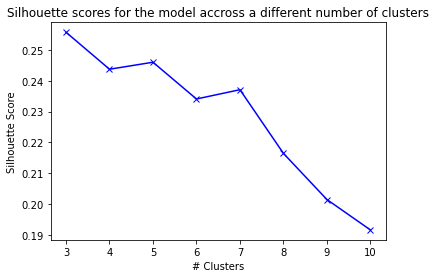

# Clusters,3,4,5,6,7,8,9,10
Silhouette Score,0.255765,0.243764,0.246033,0.234108,0.237116,0.216459,0.201482,0.191615


In [47]:
take_in_a_dataframe_of_an_algorithms_silhouette_scores_and_output_analysis_excluding_cluster_2(cluster_nd_score_nn_df)

Based on these results, it is clear that the next maximum Silhouette Score comes from the KMeans algorithm as when we exclude two clusters from this analysis, using six clusters produces the next maximum silhouette score of nearly 0.27.

As a result of this, we propose to analyse the data using the KMeans algorithm with 6 clusters to see how the subjects fall into these clusters.

When we used 2 clusters last time, we didn't get much added information as the subjects ended up just being clustered into their respective age groups. Whereas when we use 6, we expect there to be sub-clusters within these different groups that will serve to detect more specific groups of people who have more dissimilar ways of making decisions.

## Further verification of optimal number of clusters using elbow curve of distortions

#### Calculate distortion scores for different numbers of clusters

In [48]:
distortions = []
num_clusters_to_iter = range(2,11)
for k in num_clusters_to_iter:
    kmeanModel = KMeans(n_clusters=k).fit(scaled_train_df)
    distortions.append(sum(np.min(cdist(scaled_train_df, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / scaled_train_df.shape[0])

#### Plot the elbow curve of the distortion that each cluster gives

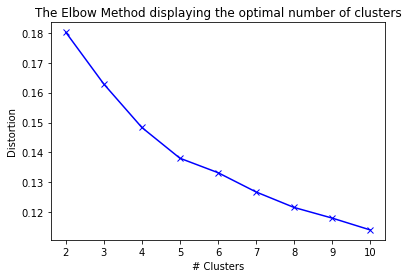

In [49]:
plt.plot(num_clusters_to_iter, distortions, 'bx-')
plt.xlabel('# Clusters')
plt.ylabel('Distortion')
plt.title('The Elbow Method displaying the optimal number of clusters')
plt.show()

As we can see above, the rate of decrease in distortion begins to diminish once it passes 6 clusters. This concurs our choice of six as the optimal number of clusters.

#### Re-choose the number of clusters

In [50]:
num_cluster_second_time = 6

=============================================================
# 8. Re-cluster the data using 6 clusters
=============================================================

#### Building the KMeans model and clustering the data

In [51]:
kmeans_model = KMeans(n_clusters=num_cluster_second_time, random_state=random_seed_val)

#### Training the model and storing predicted cluster labels

In [52]:
second_cluster_labels_array = kmeans_model.fit_predict(scaled_train_df)

#### Get the centroids of these clusters

In [53]:
centroids = kmeans_model.cluster_centers_

In [54]:
centroids_df = pd.DataFrame(centroids, columns=scaled_train_df.columns)

In [55]:
centroids_df

,LR,Out_Sens,Res_Cons,Loss_Aver,Gain_Impa,Loss_Impa,Deca_Rate,RL_weight
0,-0.032471,0.042616,0.059983,-0.019006,-0.078764,-0.077391,0.061948,0.047959
1,0.034214,-0.079584,-0.008504,-0.014698,0.079838,0.085922,-0.115248,-0.092626
2,-0.042221,0.063690,-0.086186,-0.013595,0.019997,0.021461,0.036838,0.051116
3,0.515193,-0.110436,0.105472,-0.082967,-0.048957,-0.074280,-0.108182,-0.002396
4,-0.012184,0.082587,0.013473,0.162162,0.048976,0.037592,0.042073,0.064674
5,0.029271,-0.094839,0.035598,-0.044714,-0.047915,-0.048742,-0.017808,-0.066402


#### Turn the labels array into a DataFrame so it can be concatenated with the rest of the data

In [56]:
second_cluster_labels_df = pd.DataFrame(second_cluster_labels_array, columns=['Cluster'])

In [57]:
second_cluster_labels_df.head()

,Cluster
0,0
1,0
2,0
3,2
4,0


In order to visualise these clusters, we will need to reduce the dimensionality of the original Dataframe so that we can represent each data point in a two dimensional space. This can be achieved by performing **Principal Component Analysis** on the data. This is done below.

=============================================================
# 9. Principal Component Analysis
=============================================================

There are eight parameters in this model so principal component analysis is performed below to encapsulate this information into **three principal component axes**.

#### Add the centroid data to the scaled data

In [58]:
individuals_nd_centroids_df = pd.concat([scaled_train_df, centroids_df], axis=0)

#### Inspect dataframe which PCA is being performed on

In [59]:
individuals_nd_centroids_df.head()

,LR,Out_Sens,Res_Cons,Loss_Aver,Gain_Impa,Loss_Impa,Deca_Rate,RL_weight
0,-0.040608,0.050960,-0.049978,0.013716,-0.068138,-0.087736,0.113763,0.045572
1,-0.031540,0.050908,0.122406,-0.104344,-0.040659,-0.051727,0.009016,0.117250
2,-0.031797,0.030943,0.027133,-0.079499,-0.055125,-0.073519,0.037588,0.079980
3,-0.043933,0.054810,-0.107098,-0.017930,-0.047214,-0.056205,0.094949,0.064463
4,-0.012752,0.055247,0.193987,-0.087016,-0.073679,-0.135396,0.014513,0.039631


#### Use PCA to project the data to 3 dimensions

In [60]:
# set the number of components
pca = PCA(n_components=3)

# create an array transforming the daa into these 3 components
principal_components_array = pca.fit_transform(individuals_nd_centroids_df)

# turn this array to a dataframe
principal_components_df = pd.DataFrame(data = principal_components_array, columns = ['PC1', 'PC2', 'PC3'])

In [61]:
principal_components_df.head()

,PC1,PC2,PC3
0,-0.156070,0.069499,-0.029578
1,-0.076813,0.118766,0.000360
2,-0.086327,0.103496,-0.041220
3,-0.150284,0.021520,-0.074752
4,-0.052569,0.213872,0.040760


#### Look at how much variance these 3 axes explain

In [62]:
print(pca.explained_variance_ratio_)

print("\nWhen projecting the data onto the three principal componets, approximately {}% of the variance in the original data is retained".format(round(pca.explained_variance_ratio_.sum(), 3)*100))

[0.35168356 0.24934943 0.13503315]

When projecting the data onto the three principal componets, approximately 73.6% of the variance in the original data is retained


#### Remove the centroid data from this table

In [63]:
individual_pca_df = principal_components_df.iloc[:-6, :]

pca_centroid_df = principal_components_df.iloc[-6:, :]

#### Add these principal component columns and the cluster labels to the rest of the data

In [64]:
final_full_scaled_df = pd.concat([scaled_full_df, individual_pca_df, second_cluster_labels_df], axis = 1)

In [65]:
final_full_scaled_df.head()

,group,LR,Out_Sens,Res_Cons,Loss_Aver,Gain_Impa,Loss_Impa,Deca_Rate,RL_weight,PC1,PC2,PC3,Cluster
0,young,-0.040608,0.050960,-0.049978,0.013716,-0.068138,-0.087736,0.113763,0.045572,-0.156070,0.069499,-0.029578,0
1,young,-0.031540,0.050908,0.122406,-0.104344,-0.040659,-0.051727,0.009016,0.117250,-0.076813,0.118766,0.000360,0
2,young,-0.031797,0.030943,0.027133,-0.079499,-0.055125,-0.073519,0.037588,0.079980,-0.086327,0.103496,-0.041220,0
3,young,-0.043933,0.054810,-0.107098,-0.017930,-0.047214,-0.056205,0.094949,0.064463,-0.150284,0.021520,-0.074752,2
4,young,-0.012752,0.055247,0.193987,-0.087016,-0.073679,-0.135396,0.014513,0.039631,-0.052569,0.213872,0.040760,0


=============================================================
# 10. Plot the 6 clusters using the PCA axes
=============================================================

## Plot the clusters

#### Choose the columns to plot

In [66]:
pc1 = final_full_scaled_df['PC1']
pc2 = final_full_scaled_df['PC2']
pc3 = final_full_scaled_df['PC3']
group = final_full_scaled_df['group']
cluster = final_full_scaled_df['Cluster']
all_rows = pd.Series(["All"] * len(final_full_scaled_df))

#### Check the minimum and maximum values across all axes

In [67]:
print("pc1", min(pc1), max(pc1))
print("pc2", min(pc2), max(pc2))
print("pc3", min(pc3), max(pc3))

pc1 -0.23165377890198954 0.40390335839173097
pc2 -0.1833868760203309 0.2872206893848648
pc3 -0.1365018740401349 0.29926606531935634


#### Create function to visualise 3D projection

In [92]:
def plot_3d_principal_component_points(targets, colours, column_to_colour_cluster_with, title, pca_centroid_df=pd.DataFrame()):
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # title the axes
    ax.set_xlabel('Principal Component 1', fontsize = 10)
    ax.set_ylabel('Principal Component 2', fontsize = 10)
    ax.set_zlabel('Principal Component 3', fontsize = 10)

    # set limits on the plot
    ax.set_xlim([-0.23, 0.4])
    ax.set_ylim([-0.2, 0.3])
    ax.set_zlim([-0.15, 0.3])
    ax.set_title(title)

    # plot the points
    for target, colour in zip(targets, colours):
        ax.scatter(pc1.loc[column_to_colour_cluster_with == target], pc2.loc[column_to_colour_cluster_with == target], pc3.loc[column_to_colour_cluster_with == target], c=colour, s=100, marker='o', edgecolors='grey')
    
    if not pca_centroid_df.empty:
        ax.scatter(pca_centroid_df['PC1'], pca_centroid_df['PC2'], pca_centroid_df['PC3'], c='black', s=100, marker='X')
        
    ax.legend(targets)
    plt.show()

#### Plot the original data

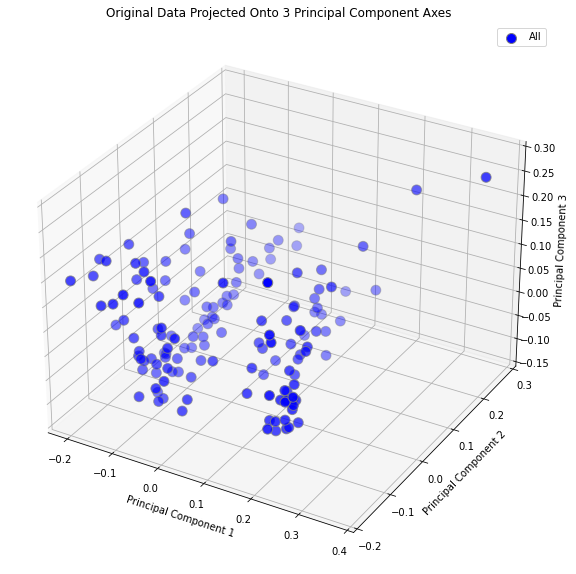

In [93]:
targets = ["All"]
colours = ['blue']

plot_3d_principal_component_points(targets, colours, all_rows, 'Original Data Projected Onto 3 Principal Component Axes')

#### Plot the data colouring the different clusters

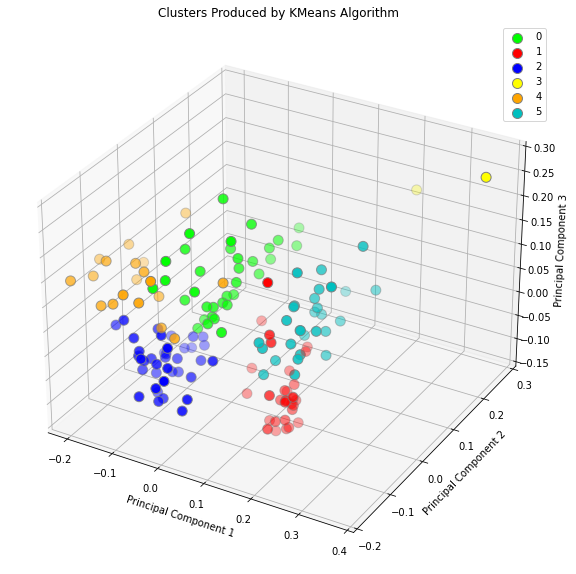

In [94]:
targets = [0, 1, 2, 3, 4, 5]
colours = ['lime', 'red', 'blue', 'yellow', 'orange', 'c']

plot_3d_principal_component_points(targets, colours, cluster, 'Clusters Produced by KMeans Algorithm')

#### Plot the data colouring the different clusters & plotting their centroids

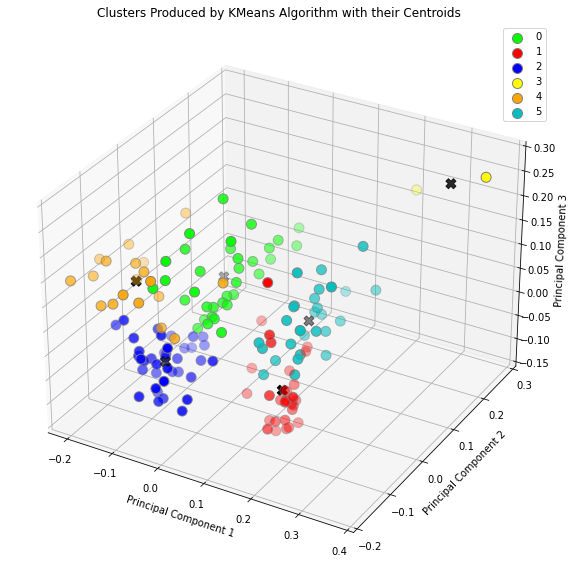

In [95]:
targets = [0, 1, 2, 3, 4, 5]
colours = ['lime', 'red', 'blue', 'yellow', 'orange', 'c']

plot_3d_principal_component_points(targets, colours, cluster, 'Clusters Produced by KMeans Algorithm with their Centroids', pca_centroid_df)

#### Plot the data colouring the different groups

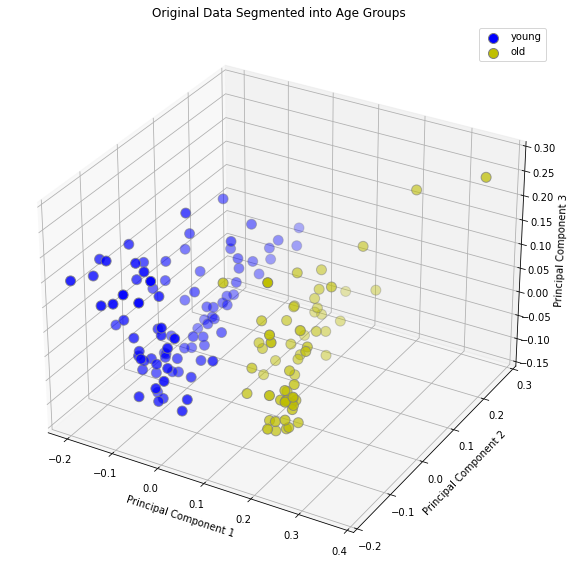

In [98]:
targets = ['young', 'old']
colours = ['b', 'y']

plot_3d_principal_component_points(targets, colours,group, 'Original Data Segmented into Age Groups')

=============================================================

# 11. Analyse these 6 clusters

=============================================================

## a.) See how the 'old' and 'young' fall into these clusters

In [73]:
see_how_the_young_and_old_fall_into_the_clusters(final_full_scaled_df)

,All,Young,Old
Cluster,,,
0,34,34,0
1,31,0,31
2,38,38,0
3,2,0,2
4,19,18,1
5,29,0,29


## b.) Characterising the clusters based on their different *cognitive attributes*
As Lili states in the paper, a subject's performance on the IGT can be interpreted as a *synthesis of several different underlying psychological processes* [4]. As such, the parameters of the VPP model can be treated as neuro-psychologically interpretable variables. Some details on the semantics of each variable is given below:

 * **LR** $ \Leftrightarrow $ **Learning Rate**: Quantifies the rate at which the subject learns through experience.
 * **Out_Sens** $ \Leftrightarrow $ **Outcome Sensitivity**: Accounts for the effects of win frequency. Subjects with a value less than 1 prefer decks with high win frequency over decks with the same long-term rewards but much less win frequency.
 * **Res_Cons** $ \Leftrightarrow $ **Response Consistency**: Quantifies the consistency of the subjects choices.
 * **Loss_Aver** $ \Leftrightarrow $ **Loss Aversion**: Responsible for the subjects sensitivity to loss relative to gains.
 * **Gain_Impa** $ \Leftrightarrow $ **Gain Impact**: Quantifies the impact of gain on the perseverance behaviour of the subject.
 * **Loss_Impa** $ \Leftrightarrow $ **Loss Impact**: Quantifies the impact of loss on the perseverance behaviour of the subject.
 * **Deca_Rate** $ \Leftrightarrow $ **Decay Rate**: The decay parameter which controls how quickly decision makers forget their past deck choices.
 * **RL_weight** $ \Leftrightarrow $ **Reinforcement Learning Weight**: Assumes values between 0 and 1. A low value indicates that the subject would rely less on reinforcement learning but more on the perseverance heuristic [3]. Whereas, a high value indicates the converse.
 
Based on these parameters, we can examine each cluster and characterise the decision-making tendencies of the subjects in that cluster. To do this, we need the original dataset before it was standardised; we append the cluster labels to this original DataFrame below.

In [74]:
df_final = pd.concat([chosen_df, second_cluster_labels_df], axis=1)
df_final.head()

,group,LR,Out_Sens,Res_Cons,Loss_Aver,Gain_Impa,Loss_Impa,Deca_Rate,RL_weight,Cluster
0,young,0.038441,0.630402,1.207295,1.050323,-0.535035,-1.913099,0.669323,0.660446,0
1,young,0.045673,0.630331,1.628191,0.205205,-0.133367,-1.423580,0.427207,0.719352,0
2,young,0.045468,0.602974,1.395572,0.383055,-0.344822,-1.719826,0.493249,0.688723,0
3,young,0.035789,0.635677,1.067831,0.823790,-0.229192,-1.484455,0.625835,0.675971,2
4,young,0.060655,0.636276,1.802964,0.329246,-0.616020,-2.561017,0.439912,0.655563,0


#### Create functions to help analyse parameters

The below functions will be useful for this piece of analysis. The first extracts the subjects from a specified cluster and provides a breakdown of the distribution of their parameters. While the second plots the distributions of each variable in a cluster.

In [75]:
def analyse_cluster_params(df, cluster_label):
    cluster_df = df[df['Cluster'] == cluster_label].iloc[:, 1:-1]
    return cluster_df.describe()

In [76]:
def plot_cluster_params(df, cluster_label, ax):
    cluster_df = df[df['Cluster'] == cluster_label].iloc[:, 1:-1]
    for i, col in enumerate(cluster_df.columns):
        sns.histplot(data=cluster_df, x=col, kde=True, ax=axes[i])
    plt.show()

### Summary statistics for entire subject group

In [77]:
df_final.iloc[:, 1:-1].describe()

,LR,Out_Sens,Res_Cons,Loss_Aver,Gain_Impa,Loss_Impa,Deca_Rate,RL_weight
count,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000
mean,0.070824,0.560575,1.329323,0.952138,0.460940,-0.720379,0.406367,0.622995
std,0.064683,0.111139,0.198041,0.580621,1.185591,1.102656,0.187483,0.066657
min,0.027454,0.352471,0.879707,0.193857,-2.977630,-2.912838,0.042780,0.452978
25%,0.038294,0.448811,1.202790,0.528927,-0.287230,-1.634716,0.256420,0.569390
50%,0.050247,0.590334,1.316736,0.760613,0.593115,-0.779120,0.439912,0.640917
75%,0.078495,0.646090,1.428836,1.292569,1.419412,0.137599,0.565139,0.675971
max,0.617431,0.818137,1.938694,2.698527,2.559126,1.583109,0.858421,0.744017


### Analsye Cluster 0

In [78]:
analyse_cluster_params(df_final, 0)

,LR,Out_Sens,Res_Cons,Loss_Aver,Gain_Impa,Loss_Impa,Deca_Rate,RL_weight
count,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000
mean,0.044930,0.618968,1.475779,0.816085,-0.690345,-1.772467,0.549555,0.662408
std,0.009610,0.055746,0.214690,0.433378,0.811496,0.576240,0.086004,0.039829
min,0.027454,0.514825,1.144924,0.205205,-2.977630,-2.750683,0.327646,0.559136
25%,0.037697,0.584808,1.296579,0.431615,-1.058930,-2.132671,0.488916,0.641616
50%,0.045361,0.623354,1.422935,0.718892,-0.534546,-1.810896,0.571731,0.663733
75%,0.051248,0.640286,1.632197,1.262242,-0.086096,-1.372874,0.598075,0.687539
max,0.064735,0.757811,1.938694,1.634251,0.501664,-0.111529,0.685362,0.721415


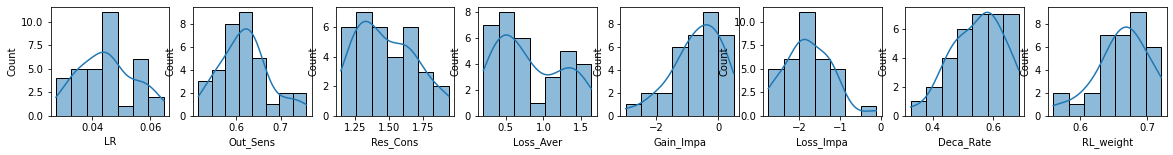

In [79]:
fig, axes = plt.subplots(ncols=8, figsize=(20,2))

plot_cluster_params(df_final, 0, axes)

There are 34 subjects in this cluster, all of which are aged between 18 and 34 years (*group='young'*). The mean Outcome Sensitivity parameter of this group was 0.62; this indicates that subjects in this cluster prefered decks with high win frequency over decks with the same long-term rewards but much less win frequency. These subjects were less sensitive to win frequency than other clusters. 

The Gain and Loss Impact parameters also reveal some interesting characteristics of subjects in the cluster. With both distributions mainly encompassing negative values, this indicates that the feedback subjects received from deck choices, both good and bad, reinforced a tendency to switch from the chosen deck [3]. This coincides with the subjects tendency to *chase* high win frequency decks mentioned above.

### Analsye Cluster 1

In [80]:
analyse_cluster_params(df_final, 1)

,LR,Out_Sens,Res_Cons,Loss_Aver,Gain_Impa,Loss_Impa,Deca_Rate,RL_weight
count,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000
mean,0.098109,0.451529,1.308560,0.846925,1.627925,0.447691,0.139977,0.546874
std,0.050250,0.033889,0.095166,0.391407,0.492441,0.717514,0.088690,0.037163
min,0.036796,0.378060,1.150260,0.430973,0.635000,-1.274963,0.042780,0.476973
25%,0.064879,0.437173,1.227498,0.571881,1.228491,-0.093730,0.077570,0.526487
50%,0.083711,0.447644,1.295686,0.717312,1.566568,0.550330,0.104735,0.546331
75%,0.113639,0.457205,1.400418,0.976864,2.035408,0.964493,0.169572,0.568558
max,0.244435,0.541667,1.464403,2.211883,2.559126,1.583109,0.415134,0.611367


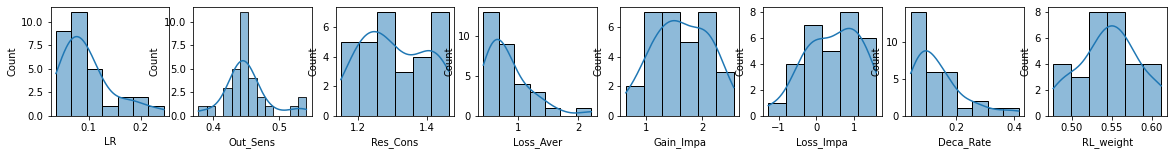

In [81]:
fig, axes = plt.subplots(ncols=8, figsize=(20,2))

plot_cluster_params(df_final, 1, axes)

The second cluster contains thirty one subjects; all aged between 65 and 88 years old (*group='old'*). We can likely expect some different characteristics between this cluster and the last due to the age difference of the subjects.

The standard deviation of the Learning Rate parameter of this cluster indicates that there is much more variability in the learning rates of the subjects in this cluster than in the last. The slightly higher values, on average, displayed in this cluster indicate that the most recent outcome has a large influence on the expectancy of the chosen deck and *forgetting is more rapid* [3]. 

The other notable differences in this cluster compared to the last is in the Gain Impact and Decay Rate parameters. Feedback, for subjects in this cluster, was far more likely to reinforce a tendency to persevere on the same deck on the next trial compared to subjects in the first cluster; as indicated by the much higher average Gain Impact value. The much lower average Decay Rate for subjects in this cluster however indicates rapid forgetting and a strong recency effect. This is probably to be expected based on age and Lili also makes this observation in the paper stating that the mean decay rate for subjects in older group is lower than that of the younger group [4].

### Analsye Cluster 2

In [82]:
analyse_cluster_params(df_final, 2)

,LR,Out_Sens,Res_Cons,Loss_Aver,Gain_Impa,Loss_Impa,Deca_Rate,RL_weight
count,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000
mean,0.037155,0.647844,1.118889,0.854820,0.753236,-0.428627,0.491517,0.665002
std,0.004996,0.032998,0.107184,0.341363,0.920465,0.819311,0.121305,0.021714
min,0.029639,0.566149,0.879707,0.325143,-1.619562,-1.826556,0.298920,0.630466
25%,0.033137,0.626812,1.058415,0.605547,-0.099744,-1.091075,0.402615,0.644570
50%,0.036932,0.650220,1.098954,0.812733,0.944684,-0.535138,0.480873,0.662299
75%,0.039418,0.669804,1.183144,1.107709,1.497192,0.032327,0.578308,0.681603
max,0.049586,0.716560,1.349812,1.531198,2.059571,1.252367,0.858421,0.701119


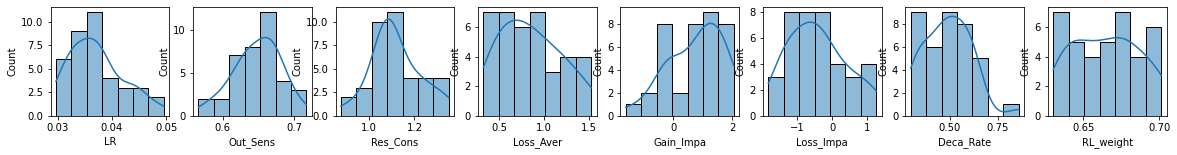

In [83]:
fig, axes = plt.subplots(ncols=8, figsize=(20,2))

plot_cluster_params(df_final, 2, axes)

The 38 subjects in this cluster, again, are all in the 'young' group. They exhibited very similar characteristics to the 'young' subjects in cluster 0 but there are a few things which set these clusters apart.

 * The most notable difference is in the Decay Rate parameter. Subjects in this cluster tended to have lower Decay Rates with a lower mean value, which could have been even lower due to the presence of one or two outliers. This indicates that subjects in this cluster forgot their past deck choices quicker than those is cluster 0, and exhibited a stronger recency effect.
 * Interestingly, subjects in this group were more likely to persevere with the same deck choice when positive feedback was received, as indicated by the higher average Gain Impact parameter, compared to cluster 0. 
 * The subjects were also less likely to switch decks upon receiving negative feedback (Loss Impact) compared to the 'young' subjects in cluster 0. The higher average value of Loss Impact is indicative of this.

### Analsye Cluster 3

In [84]:
analyse_cluster_params(df_final, 3)

,LR,Out_Sens,Res_Cons,Loss_Aver,Gain_Impa,Loss_Impa,Deca_Rate,RL_weight
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
mean,0.481673,0.409255,1.586845,0.358229,-0.254669,-1.730171,0.156310,0.621025
std,0.191991,0.014745,0.288681,0.084110,0.111644,0.134995,0.030132,0.043265
min,0.345916,0.398828,1.382717,0.298755,-0.333613,-1.825627,0.135004,0.590432
25%,0.413794,0.404042,1.484781,0.328492,-0.294141,-1.777899,0.145657,0.605729
50%,0.481673,0.409255,1.586845,0.358229,-0.254669,-1.730171,0.156310,0.621025
75%,0.549552,0.414468,1.688909,0.387967,-0.215196,-1.682444,0.166964,0.636322
max,0.617431,0.419681,1.790974,0.417704,-0.175724,-1.634716,0.177617,0.651618


In [85]:
#Plots are not needed here

df_final[df_final['Cluster'] == 3]

,group,LR,Out_Sens,Res_Cons,Loss_Aver,Gain_Impa,Loss_Impa,Deca_Rate,RL_weight,Cluster
108,old,0.617431,0.398828,1.382717,0.298755,-0.175724,-1.634716,0.177617,0.590432,3
145,old,0.345916,0.419681,1.790974,0.417704,-0.333613,-1.825627,0.135004,0.651618,3


There are only two subjects in this cluster, both from the 'old' group. It is unusual for a cluster this small to exist and it poses the question of what sets these two subjects apart from the other clusters?

 * It appears the Learning Rate of these two 'old' subjects is considerably higher than the average values in cluster 1  and cluster 5 of 0.098 and 0.094 respectively. So for these two subjects in particular, the most recent outcome had a large influence on the expectancy of the chosen deck and forgetting was more rapid [3]. These two values for learning rate are actually the highest values in the entire dataset, meaning these two subjects in particular forgot their previous choices more rapidly.
 * The Response Consistency of 1.38 for the first subject was similar to the values present in the other two 'old' clusters. But the value of 1.79 for the second subject was actually the highest Response Consistency among all 'old' subjects. This indicates a high consistency in the choices of this particular subject.

### Analsye Cluster 4

In [86]:
analyse_cluster_params(df_final, 4)

,LR,Out_Sens,Res_Cons,Loss_Aver,Gain_Impa,Loss_Impa,Deca_Rate,RL_weight
count,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000
mean,0.061108,0.673738,1.362218,2.112953,1.176818,-0.209339,0.503616,0.676144
std,0.037106,0.078943,0.131509,0.318653,0.609554,0.859685,0.119095,0.038725
min,0.035290,0.519401,1.168612,1.489912,-0.135692,-1.744153,0.254134,0.581288
25%,0.049401,0.619825,1.263198,1.914642,0.907488,-1.003000,0.442941,0.658752
50%,0.052410,0.672577,1.316736,2.153174,1.187441,-0.212460,0.516845,0.682027
75%,0.057140,0.747180,1.436604,2.319864,1.498312,0.484873,0.597212,0.701697
max,0.209782,0.818137,1.693704,2.698527,2.531642,0.940470,0.695701,0.744017


19 subjects make up the fifth cluster and interestingly, there is one 'old' subject in this cluster while the rest of the subjects are from the 'young' group. We will extract the subject from the 'old' group for reference.

In [87]:
df_final[(df_final['Cluster'] == 4) & (df_final['group'] == 'old')]

,group,LR,Out_Sens,Res_Cons,Loss_Aver,Gain_Impa,Loss_Impa,Deca_Rate,RL_weight,Cluster
136,old,0.209782,0.519401,1.263331,1.926615,1.099713,0.59945,0.61377,0.581288,4


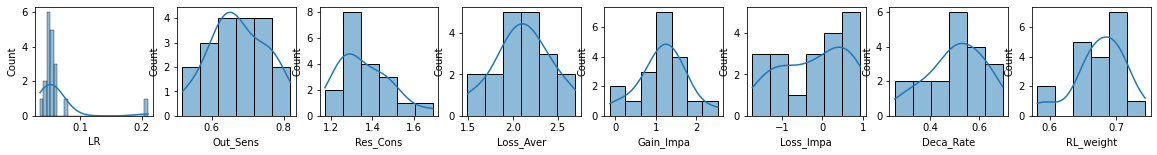

In [88]:
fig, axes = plt.subplots(ncols=8, figsize=(20,2))

plot_cluster_params(df_final, 4, axes)

This cluster should display similar characteristics to the cluster 0 and cluster 2 as these both also contain exclusively subjects from the 'young' group (bar the one 'old' subject in this cluster, of course). The Learning Rate of subjects in this cluster was, on average, slightly lower than cluster 0 and cluster 2 (The actual mean of this parameter is skewed because of the outlier value present in the 'old' subject of 0.2). This indicates that subjects in this cluster placed less weight on past experiences of the chosen deck vs. the most recent selection from the deck. This also is indicative of the fact that subjects forgot past deck choices in a more gradual manner than in the other two 'young' groups. The most recent outcome had a smaller influence on the expectancy in the next trial, for these subjects.

The other most distinguishable characteristic of this cluster compared to the other 'young' groups was the much higher Loss Aversion tendencies of this cluster. The mean Loss Aversion parameter for subjects was 2.11 compared to 0.82 in cluster 0 and 0.85 in cluster 2. When Loss Aversion is greater than 1, the influence of a loss is greater than a gain on the subject [3]. This cluster of 'young' subjects, in particular, gave more weight to losses, compared to the other two 'young' clusters. 

### Analsye Cluster 5

In [89]:
analyse_cluster_params(df_final, 5)

,LR,Out_Sens,Res_Cons,Loss_Aver,Gain_Impa,Loss_Impa,Deca_Rate,RL_weight
count,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000
mean,0.094167,0.430625,1.416240,0.632061,-0.239426,-1.382996,0.365205,0.568425
std,0.042444,0.035365,0.140328,0.363062,1.053638,0.787160,0.138316,0.058474
min,0.034678,0.352471,1.170308,0.193857,-2.576726,-2.912838,0.184651,0.452978
25%,0.065054,0.410881,1.335872,0.391450,-0.736174,-2.108210,0.242197,0.527814
50%,0.093528,0.440661,1.403124,0.567275,0.206315,-1.378078,0.341295,0.569390
75%,0.111220,0.454395,1.505701,0.715643,0.455003,-0.776568,0.502327,0.622562
max,0.217324,0.505871,1.688776,1.681583,1.268844,0.302832,0.600929,0.661746


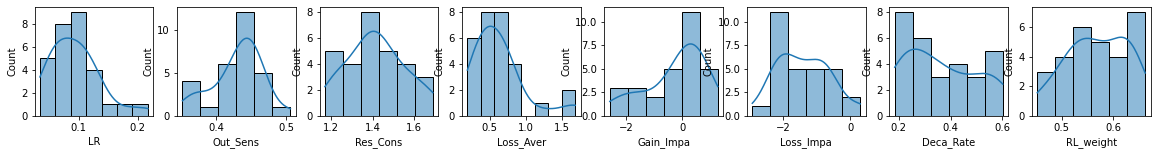

In [90]:
fig, axes = plt.subplots(ncols=8, figsize=(20,2))

plot_cluster_params(df_final, 5, axes)

There are 29 subjects in the final cluster, all from the 'old' group. They exhibit very similar characteristics to the subjects in cluster 1, which also exclusively contains 'old' subjects. This is to be expected. They do however, share some subtle differences with this other cluster.

 * The Loss Aversion of subjects in this cluster is slightly lower, on average. They were affected less by losses relative to gains than the other group, with a slightly lower mean value.
 * The Gain and Loss Impacts respectively were both, on average, much lower for subjects in this cluster comaperd to those in cluster 1. These lower, negative values indicate that the feedback received for their deck choices reinforces a tendency to switch from the chosen deck.